# Helper function for plotting 2D image

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def imageclip(image, iters=3, vmin=None, vmax=None, ax=None, cbar=True,
              return_objects=False, figsize=(6,5), **kwargs):
    
    if (not vmin is None) and (not vmax is None):
        pass
    elif np.all(image==0):
        vmin, vmax = 0 ,1
    else:
        b = image[image!=0]
        if np.min(b) == np.max(b):
            vmin, vmax = 0, 1
        else:
            if len(b) > 5e4:
                b = b[np.random.choice(len(b),int(5e4),replace=False)]
            for i in range(iters):
                if np.std(b) == 0:
                    continue
                clipmin = np.nanmedian(b) - 5*np.std(b)
                clipmax = np.nanmedian(b) + 5*np.std(b)
                b = b[(b<clipmax) & (b>clipmin)]
                
            if np.std(b) == 0:
                pass
            else:
                clipmin = np.nanmedian(b) - 3*np.std(b)
                clipmax = np.nanmedian(b) + 3*np.std(b)
                b = b[(b<clipmax) & (b>clipmin)]
                
            vmin, vmax = np.min(b), np.max(b)
        
    
    objs = {}
    objs['vmin'] = vmin
    objs['vmax'] = vmax
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=figsize)
        objs['fig'] = fig
        objs['ax'] = ax

    p = ax.imshow(image,vmin=vmin, vmax=vmax, cmap='jet', origin='lower', **kwargs)    
    objs['p'] = p
    if cbar:
        cbar = plt.colorbar(p,ax=ax)
        objs['cbar'] = cbar
        
    if return_objects:
        return objs
    else:
        return

# RMF's Function

In [13]:
import numpy as np
from hankel import SymmetricFourierTransform
from scipy import interpolate
from scipy import stats


def counts_from_density_2d(density_fields, Ntot = 200000, ell_min=90.):
    counts_map = np.zeros_like(density_fields)
    
    surface_area = (np.pi/ell_min)**2

    # compute the mean number density per cell 
    N_mean = float(Ntot) / float(counts_map.shape[-2]*counts_map.shape[-1])
    
    # calculate the expected number of galaxies per cell
    expectation_ngal = (density_fields+1.)*N_mean 
    # generate Poisson realization of 2D field
    count_maps = np.random.poisson(expectation_ngal)
    
    dcounts = np.array([int(np.sum(ct_map)-Ntot) for ct_map in count_maps])
    # if more counts in the poisson realization than Helgason number counts, subtract counts
    # from non-zero elements of array.
    # The difference in counts is usually at the sub-percent level, so adding counts will only slightly
    # increase shot noise, while subtracting will slightly decrease power at all scales
    for i in np.arange(count_maps.shape[0]):
        if dcounts[i] > 0:
            nonzero_x, nonzero_y = np.nonzero(count_maps[i])
            rand_idxs = np.random.choice(np.arange(len(nonzero_x)), dcounts[i], replace=True)
            count_maps[i][nonzero_x[rand_idxs], nonzero_y[rand_idxs]] -= 1
        elif dcounts[i] < 0:
            randx, randy = np.random.choice(np.arange(count_maps[i].shape[-1]), size=(2, np.abs(dcounts[i])))
            for j in range(np.abs(dcounts[i])):
                counts_map[i][randx[j], randy[j]] += 1

    return count_maps

''' This function generates the indices needed when generating G(k), which gets Fourier transformed to a gaussian
random field with some power spectrum.'''
def fftIndgen(n):
#     a = range(0, n//2+1)
#     b = range(1, n//2)
#     b.reverse()
#     b = [-i for i in b]
    a = np.arange(0, n//2+1)
    b = np.arange(1, n//2)
    b = -np.flip(b,0)
    return np.concatenate((a,b))

def gaussian_random_field_2d(n_samples, alpha=None, size=128, ell_min=90., cl=None, ell_sampled=None, fac=1, plot=False):
    
    up_size = size*fac
    steradperpixel = ((np.pi/ell_min)/up_size)**2
    surface_area = (np.pi/ell_min)**2

    cl_g, spline_cl_g = hankel_spline_lognormal_cl(ell_sampled, cl)
    ls = make_ell_grid(up_size, ell_min=ell_min)
    amplitude = 10**spline_cl_g(np.log10(ls))
    amplitude /= surface_area
    
    amplitude[0,0] = 0.
    
    noise = np.random.normal(size = (n_samples, up_size,up_size)) + 1j * np.random.normal(size = (n_samples, up_size, up_size))
    gfield = np.array([np.fft.ifft2(n * amplitude).real for n in noise])
    gfield /= steradperpixel
    # up to this point, the gaussian random fields have mean zero
    return gfield, amplitude, ls

def generate_count_map_2d(n_samples, ell_min=90., size=128, Ntot=2000000, cl=None, ell_sampled=None, plot=False, save=False):
    # we want to generate a GRF twice the size of our final GRF so we include larger scale modes
    realgrf, amp, k = gaussian_random_field_2d(n_samples, size=size, cl=cl, ell_sampled=ell_sampled, ell_min=ell_min/2.,fac=2)
    realgrf = realgrf[:,int(0.5*size):int(1.5*size),int(0.5*size):int(1.5*size)]
    
    density_fields = np.array([np.exp(grf-np.std(grf)**2)-1. for grf in realgrf]) # assuming a log-normal density distribution
    density_fields = np.array([df-np.mean(df) for df in density_fields]) # this ensures that each field has mean zero
    
    counts = counts_from_density_2d(density_fields, Ntot=Ntot)

    return counts, density_fields


''' This function takes an angular power spectrum and computes the corresponding power spectrum for the log 
of the density field with that power spectrum. This involves converting the power spectrum to a correlation function, 
computing the lognormal correlation function, and then transforming back to ell space to get C^G_ell.'''
def hankel_spline_lognormal_cl(ells, cl, plot=False, ell_min=90, ell_max=1e5):
    
    ft = SymmetricFourierTransform(ndim=2, N = 200, h = 0.03)
    # transform to angular correlation function with inverse hankel transform and spline interpolated C_ell
    spline_cl = interpolate.InterpolatedUnivariateSpline(np.log10(ells), np.log10(cl))
    f = lambda ell: 10**(spline_cl(np.log10(ell)))
    thetas = np.pi/ells
    w_theta = ft.transform(f ,thetas, ret_err=False, inverse=True)
    # compute lognormal angular correlation function
    w_theta_g = np.log(1.+w_theta)
    # convert back to multipole space
    spline_w_theta_g = interpolate.InterpolatedUnivariateSpline(np.log10(np.flip(thetas,0)), np.flip(w_theta_g,0))
    g = lambda theta: spline_w_theta_g(np.log10(theta))
    cl_g = ft.transform(g ,ells, ret_err=False)
    spline_cl_g = interpolate.InterpolatedUnivariateSpline(np.log10(ells), np.log10(np.abs(cl_g)))
    
    # plotting is just for validation if ever unsure
    if plot:
        plt.figure()
        plt.loglog(ells, cl, label='$C_{\\ell}$', marker='.')
        plt.loglog(ells, cl_g, label='$C_{\\ell}^G$', marker='.')
        plt.loglog(np.linspace(ell_min, ell_max, 1000), 10**spline_cl_g(np.log10(np.linspace(ell_min, ell_max, 1000))), label='spline of $C_{\\ell}^G$')
        plt.legend(fontsize=14)
        plt.xlabel('$\\ell$', fontsize=16)
        plt.title('Angular power spectra', fontsize=16)
        plt.show()
    
    return cl_g, spline_cl_g

# this is for projecting a 3D power spectrum to a 2D angular power spectrum.

def limber_project(halo_ps, zmin, zmax, ng=None, flux_prod_rate=None, nbin=20, ell_min=90, ell_max=1e5, n_ell_bin=30):
    ''' This currently takes in the dark matter halo power spectrum from the hmf package. The only place where this is
    used is when updating the redshift of the power spectrum. Should add option to use array of power spectra as well'''
    cls = np.zeros((nbin, n_ell_bin))    

    ell_space = 10**(np.linspace(np.log10(ell_min), np.log10(ell_max), n_ell_bin))
    zs = np.linspace(zmin, zmax, nbin+1)
    dz = zs[1]-zs[0]
    central_zs = 0.5*(zs[1:]+zs[:-1])
    
    D_A = cosmo.angular_diameter_distance(central_zs)/cosmo.h # has units h^-1 Mpc
    H_z = cosmo.H(central_zs) # has units km/s/Mpc (or km/s/(h^-1 Mpc)?)
    inv_product = (cosmo.h*dz*H_z)/(const.c.to('km/s')*(1.+central_zs)*D_A**2)
    
    for i in range(nbin):
        halo_ps.update(z=central_zs[i])
        ks = ell_space / (cosmo.comoving_distance(central_zs[i]))
        log_spline = interpolate.InterpolatedUnivariateSpline(np.log10(halo_ps.k), np.log10(halo_ps.nonlinear_power))    
        ps = 10**(log_spline(np.log10(ks.value)))
        cls[i] = ps

    ''' One can compute the auto and cross power spectrum for intensity maps/tracer catalogs 
    by specifying flux_prod_rate and/or ng (average number of galaxies per steradian)''' 
    
    if flux_prod_rate is not None:
        if ng is not None:
            cls = np.array([flux_prod_rate[i]*ng**(-1)*inv_product[i]*cls[i] for i in range(inv_product.shape[0])])
        else:
            cls = np.array([flux_prod_rate[i]**2*inv_product[i]*cls[i] for i in range(inv_product.shape[0])])
    else:
        if ng is not None:
            cls = np.array([ng**(-2)*inv_product[i]*cls[i] for i in range(inv_product.shape[0])])
        else:
            cls = np.array([inv_product[i]*cls[i] for i in range(inv_product.shape[0])])

    integral_cl = np.sum(cls, axis=0)

    return ell_space, integral_cl

''' This is used when making gaussian random fields '''
def make_ell_grid(size, ell_min=90.):
    size = int(size)
    ell_grid = np.zeros(shape=(size,size))
    size_ind = np.array(fftIndgen(size))
    for i, sx in enumerate(size_ind):
        ell_grid[i,:] = np.sqrt(sx**2+size_ind**2)*ell_min
    return ell_grid



''' Given a counts map, generate source catalog positions consistent with those counts. 
Not doing any subpixel position assignment or anything like that.''' 
def positions_from_counts(counts_map, cat_len=None):
    thetax, thetay = [], []
    for i in np.arange(np.max(counts_map)):
        pos = np.where(counts_map > i)
        thetax.extend(pos[0].astype(np.float))
        thetay.extend(pos[1].astype(np.float))

    if cat_len is not None:
        idxs = np.random.choice(np.arange(len(thetax)), cat_len)
        thetax = np.array(thetax)[idxs]
        thetay = np.array(thetay)[idxs]

    return np.array(thetax), np.array(thetay)

# Make an input Cl

Text(0.5, 1.0, 'Input Cl')

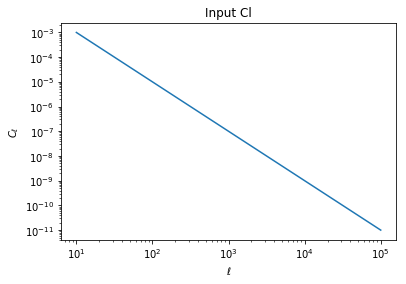

In [10]:
from astropy import units as u

ells = np.logspace(1,5,100)
logx, logy =np.array([np.log10(1e2),np.log10(1e3)]), np.array([np.log10(100),np.log10(1)])
x, y = 10**logx, 10**logy
logCl = scipy.interpolate.InterpolatedUnivariateSpline(logx, logy, k=1)
cl = 10**logCl(np.log10(ells))
cl = cl/1e7

plt.loglog(ells, cl)
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')
plt.title('Input Cl')

# Make a density field of 8x8 deg$^2$ (64x CIBER Fov)

## Turn on lognormal in Hankel (original code)

In [14]:
ell_min = 90
Npix = 1024
deg_pix = 2/Npix

upscale = 4
counts4, density_fields4 = generate_count_map_2d(1,
                                               ell_min=ell_min/upscale,
                                               cl=cl, 
                                               ell_sampled=ells,
                                               size=Npix*upscale,
                                              Ntot=1000)
ra4, dec4 = positions_from_counts(counts4[0])
ra4 = (ra4 - (Npix*upscale-1)/2) * deg_pix
dec4 = (dec4 - (Npix*upscale-1)/2) * deg_pix


/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in log10


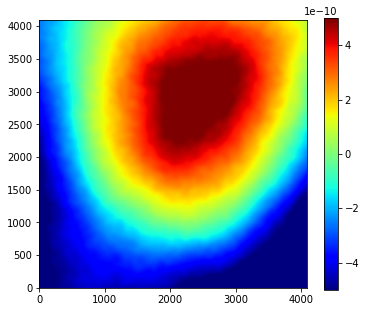

In [20]:
imageclip(density_fields4[0], vmin=-5e-10, vmax=5e-10)

# Turnoff lognormal in Hankel

In [12]:
def hankel_spline_lognormal_cl(ells, cl, plot=False, ell_min=90, ell_max=1e5):
    
    ft = SymmetricFourierTransform(ndim=2, N = 200, h = 0.03)
    # transform to angular correlation function with inverse hankel transform and spline interpolated C_ell
    spline_cl = interpolate.InterpolatedUnivariateSpline(np.log10(ells), np.log10(cl))
    f = lambda ell: 10**(spline_cl(np.log10(ell)))
    thetas = np.pi/ells
    w_theta = ft.transform(f ,thetas, ret_err=False, inverse=True)
    # compute lognormal angular correlation function
    w_theta_g = np.log(1.+w_theta)
    # convert back to multipole space
    spline_w_theta_g = interpolate.InterpolatedUnivariateSpline(np.log10(np.flip(thetas,0)), np.flip(w_theta_g,0))
    g = lambda theta: spline_w_theta_g(np.log10(theta))
    cl_g = ft.transform(g ,ells, ret_err=False)
#     spline_cl_g = interpolate.InterpolatedUnivariateSpline(np.log10(ells), np.log10(np.abs(cl_g)))
    # YTC: turn off the log density field
    spline_cl_g = interpolate.InterpolatedUnivariateSpline(np.log10(ells), np.log10(np.abs(cl)))####
    
    # plotting is just for validation if ever unsure
    if plot:
        plt.figure()
        plt.loglog(ells, cl, label='$C_{\\ell}$', marker='.')
        plt.loglog(ells, cl_g, label='$C_{\\ell}^G$', marker='.')
        plt.loglog(np.linspace(ell_min, ell_max, 1000), 10**spline_cl_g(np.log10(np.linspace(ell_min, ell_max, 1000))), label='spline of $C_{\\ell}^G$')
        plt.legend(fontsize=14)
        plt.xlabel('$\\ell$', fontsize=16)
        plt.title('Angular power spectra', fontsize=16)
        plt.show()
    
    return cl_g, spline_cl_g

In [7]:
ell_min = 90
Npix = 1024
deg_pix = 2/Npix

upscale = 4
counts4, density_fields4 = generate_count_map_2d(1,
                                               ell_min=ell_min/upscale,
                                               cl=cl, 
                                               ell_sampled=ells,
                                               size=Npix*upscale,
                                              Ntot=1000)
ra4, dec4 = positions_from_counts(counts4[0])
ra4 = (ra4 - (Npix*upscale-1)/2) * deg_pix
dec4 = (dec4 - (Npix*upscale-1)/2) * deg_pix


/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in log10


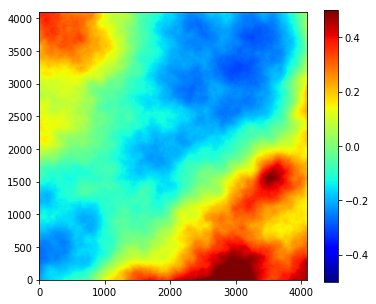

In [11]:
imageclip(density_fields4[0],vmin=-0.5, vmax=0.5)

# Code for making the Jan. 09 Posting plot

### Window Function Test

/Users/ytcheng/ciber/python_ciber/stack_modelfit/make_maps_RMF.py:57: RuntimeWarning: divide by zero encountered in log10
  amplitude = 10**spline_cl_g(np.log10(ls))
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:53: RuntimeWarning: invalid value encountered in greater_equal
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:55: RuntimeWarning: invalid value encountered in less
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in greater_equal
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in less
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in greater_equal
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in less
/Users/ytcheng/ciber/python_ciber

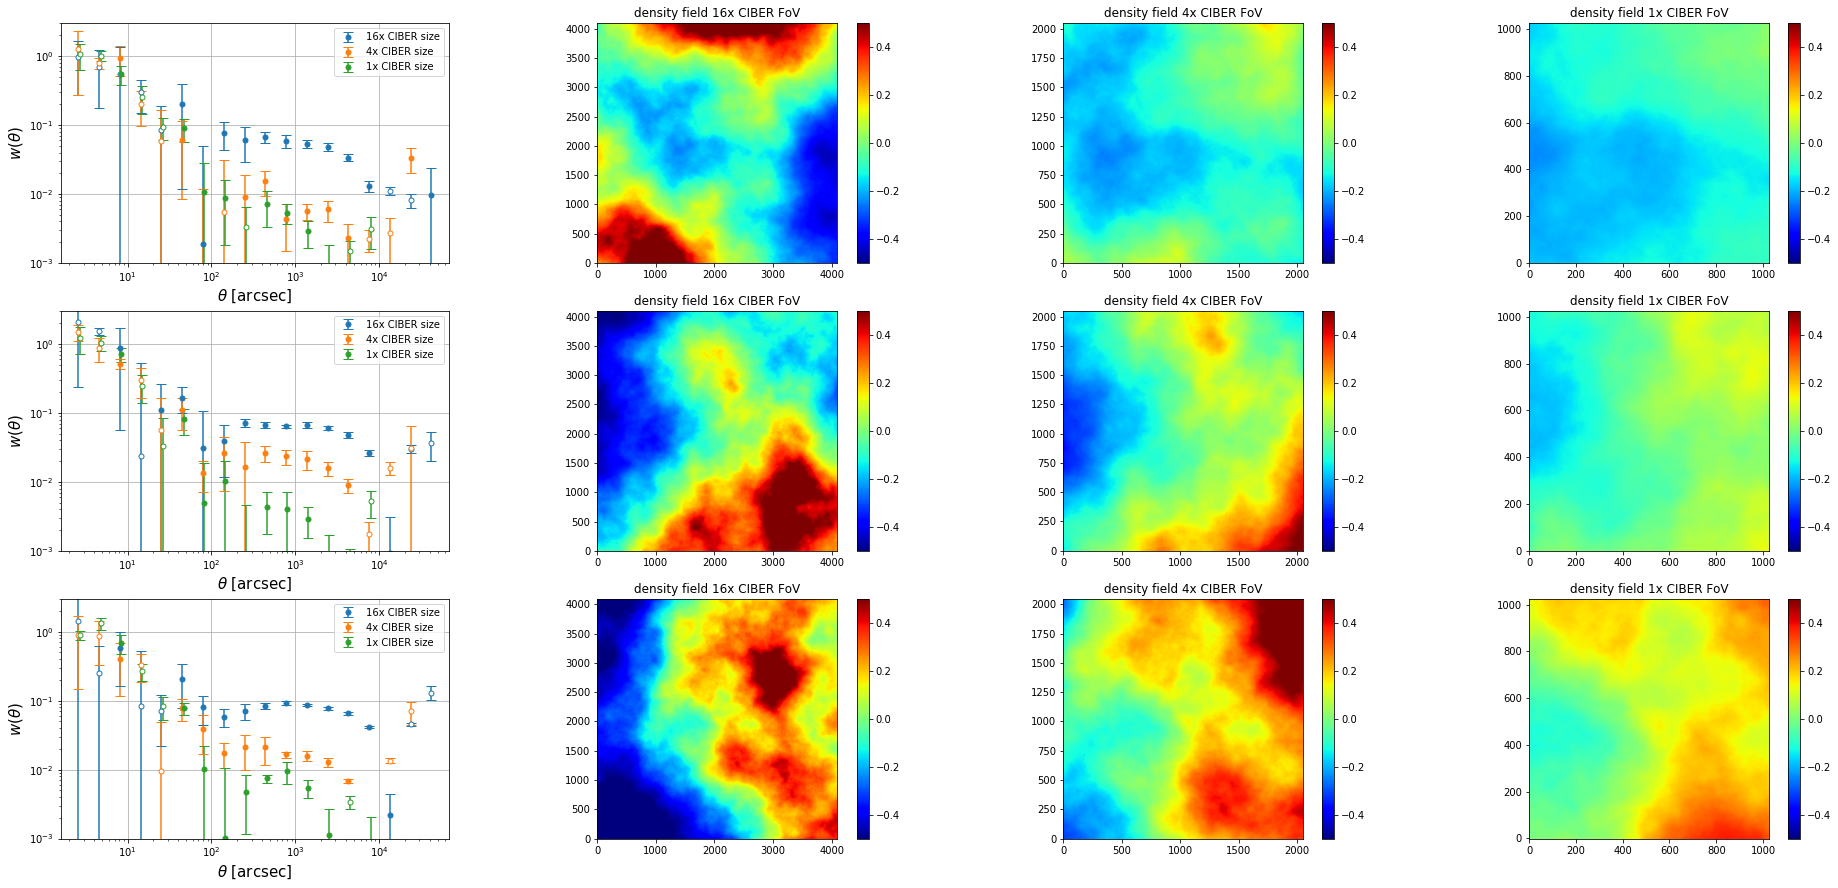

In [21]:
from astropy import units as u
from utils import *
from clustering import *
from make_maps_RMF import *

ells = np.logspace(1,5,100)
logx, logy =np.array([np.log10(1e2),np.log10(1e3)]), np.array([np.log10(100),np.log10(1)])
x, y = 10**logx, 10**logy
logCl = scipy.interpolate.InterpolatedUnivariateSpline(logx, logy, k=1)
cl = 10**logCl(np.log10(ells))
cl = cl/1e7

ell_min = 90
Npix = 1024
deg_pix = 2/Npix
fig, ax = plt.subplots(3,4,figsize=(32,15))
for i in range(3):
    upscale = 4
    counts4, density_fields4 = generate_count_map_2d(1,
                                                   ell_min=ell_min/upscale,
                                                   cl=cl, 
                                                   ell_sampled=ells,
                                                   size=Npix*upscale,
                                                  Ntot=10000)
    ra4, dec4 = positions_from_counts(counts4[0])
    ra4 = (ra4 - (Npix*upscale-1)/2) * deg_pix
    dec4 = (dec4 - (Npix*upscale-1)/2) * deg_pix

    upscale = 2
    density_fields2 = density_fields4[:,density_fields4.shape[1]//4:density_fields4.shape[1]//4*3+1,
                     density_fields4.shape[1]//4:density_fields4.shape[1]//4*3+1]    
    counts2 = counts_from_density_2d(density_fields2, Ntot=10000)
    ra2, dec2 = positions_from_counts(counts2[0])
    ra2 = (ra2 - (Npix*upscale-1)/2) * deg_pix
    dec2 = (dec2 - (Npix*upscale-1)/2) * deg_pix

    upscale = 1
    density_fields1 = density_fields2[:,density_fields2.shape[1]//4:density_fields2.shape[1]//4*3+1,
                     density_fields2.shape[1]//4:density_fields2.shape[1]//4*3+1]    
    counts1 = counts_from_density_2d(density_fields1, Ntot=10000)
    ra1, dec1 = positions_from_counts(counts1[0])
    ra1 = (ra1 - (Npix*upscale-1)/2) * deg_pix
    dec1 = (dec1 - (Npix*upscale-1)/2) * deg_pix


    theta_binedges_arcsec = np.logspace(0.3,5,20) # arcsec
    theta_binedges_deg = (theta_binedges_arcsec * u.arcsec).to(u.deg).value # deg
    theta_bins = np.sqrt(theta_binedges_arcsec[1:] * theta_binedges_arcsec[:-1])
    corr1, dcorr1, _ = get_angular_2pt_func(ra1, dec1, theta_binedges_deg, nboot=5)
    corr2, dcorr2, _ = get_angular_2pt_func(ra2, dec2, theta_binedges_deg, nboot=5)
    corr4, dcorr4, _ = get_angular_2pt_func(ra4, dec4, theta_binedges_deg, nboot=5)

    ax[i][0].errorbar(theta_bins[corr4>=0]*0.98, corr4[corr4>=0], dcorr4[corr4>=0],
                fmt='.', color='C'+str(0),capsize=5, markersize=10, alpha=1, label='16x CIBER size')
    ax[i][0].errorbar(theta_bins[corr4<0]*0.98, -corr4[corr4<0], dcorr4[corr4<0],
                fmt='.', mfc='white', color='C'+str(0),capsize=5, markersize=10, alpha=1)

    ax[i][0].errorbar(theta_bins[corr2>=0]*0.98, corr2[corr2>=0], dcorr2[corr2>=0],
                fmt='.', color='C'+str(1),capsize=5, markersize=10, alpha=1, label='4x CIBER size')
    ax[i][0].errorbar(theta_bins[corr2<0]*0.98, -corr2[corr2<0], dcorr2[corr2<0],
                fmt='.', mfc='white', color='C'+str(1),capsize=5, markersize=10, alpha=1)

    ax[i][0].errorbar(theta_bins[corr1>=0]*1.02, corr1[corr1>=0], dcorr1[corr1>=0],
                fmt='.', color='C'+str(2),capsize=5, markersize=10, alpha=1, label='1x CIBER size')
    ax[i][0].errorbar(theta_bins[corr1<0]*1.02, -corr1[corr1<0], dcorr1[corr1<0],
                fmt='.', mfc='white', color='C'+str(2),capsize=5, markersize=10, alpha=1)


    ax[i][0].set_xscale('log')
    ax[i][0].set_yscale('log')
    ax[i][0].set_xlabel(r'$\theta$ [arcsec]', fontsize=15)
    ax[i][0].set_ylabel(r'$w(\theta)$', fontsize=15)
    ax[i][0].legend()
    ax[i][0].set_ylim([1e-3,3e0])
    ax[i][0].grid()

    imageclip(density_fields4[0], ax=ax[i][1], vmin=-0.5, vmax=0.5)
    ax[i][1].set_title('density field 16x CIBER FoV')
    imageclip(density_fields2[0], ax=ax[i][2], vmin=-0.5, vmax=0.5)
    ax[i][2].set_title('density field 4x CIBER FoV')
    imageclip(density_fields1[0], ax=ax[i][3], vmin=-0.5, vmax=0.5)
    ax[i][3].set_title('density field 1x CIBER FoV')
    
plt.savefig('/Users/ytcheng/Desktop/wgg_window_test.png', dpi = 150, bbox_inches='tight')